# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd

strategyArray = []
gainArray     = []
lossArray     = []
ampNumber     = 4

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

features, result = loadDataset()

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i]) 
                lossError += getLossError(predicted[i + 1], expected[i + 1])
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):   
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = gainArray

    axis.boxplot(data)
    axis.set_title("Gain error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [6]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = lossArray

    axis.boxplot(data)
    axis.set_title("Loss error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotDistribution(regressor):
    features, result = loadDataset()
    regressor.fit(features, result)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vGain     = np.vectorize(invertGainNorm)
    vLoss     = np.vectorize(invertLossNorm)
    
    axis.scatter(vGain(result[:, 0]), vLoss(result[:, 1]))
    axis.scatter(vGain(predicted[:, 0]), vLoss(predicted[:, 1]), c = "m")

    axis.set_title(strategyArray[-1])
    axis.set_xlabel("Gain")
    axis.set_ylabel("Loss")
    axis.legend(["expected", "predicted"])

    plt.show()

In [8]:
def plotGainDistribution(regressor):
    features, result = loadDataset()

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertGainNorm)
    
    axis.scatter(vFunc(result[:, 0]), vFunc(predicted[:, 0]))
    axis.set_title("Gain Distribution - {}".format(strategyArray[-1]))
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

In [9]:
def plotLossDistribution(regressor):
    features, result = loadDataset()

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertLossNorm)
    
    axis.scatter(vFunc(result[:, 1]), vFunc(predicted[:, 1]), c = "m")
    axis.set_title("Loss Distribution - {}".format(strategyArray[-1]))
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

# Putting all together

In [10]:
gainArray = []
lossArray = []

[2.36894479 1.70390036 1.81624107 1.86718597 2.04037207] => 1.96 (+/- 0.46)
[2.04465254 2.01622549 2.2279608  2.51235419 2.34939315] => 2.23 (+/- 0.37)


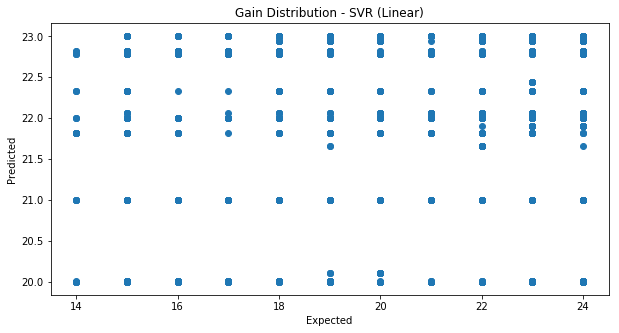

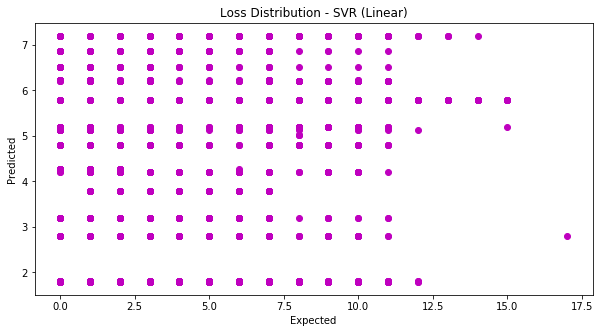

In [11]:
linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(linearSVR)
strategyArray.append("SVR (Linear)")
#plotDistribution(linearSVR)
plotGainDistribution(linearSVR)
plotLossDistribution(linearSVR)

[2.1341397  1.76198338 2.12317876 1.95474162 2.00499336] => 2.00 (+/- 0.27)
[2.17502457 1.9903105  2.16155044 2.24139334 1.92055817] => 2.10 (+/- 0.24)


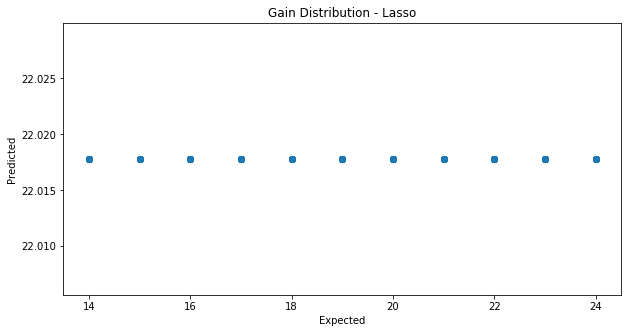

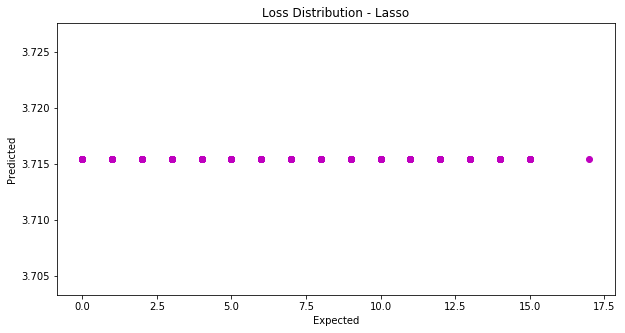

In [12]:
lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
trainModel(lasso)
strategyArray.append("Lasso")
#plotDistribution(lasso)
plotGainDistribution(lasso)
plotLossDistribution(lasso)

[2.1842755  1.76488505 2.05707374 1.97245406 2.0055925 ] => 2.00 (+/- 0.27)
[2.1431484  1.96989534 2.14568218 2.15362086 1.90599084] => 2.06 (+/- 0.21)


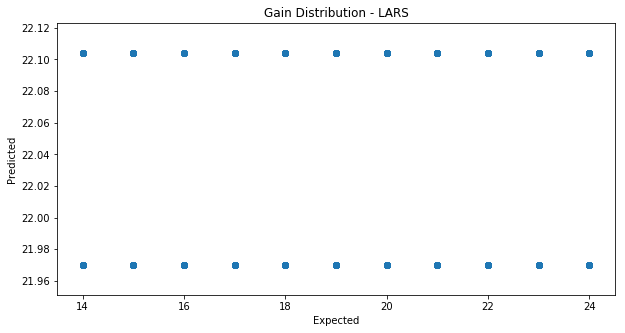

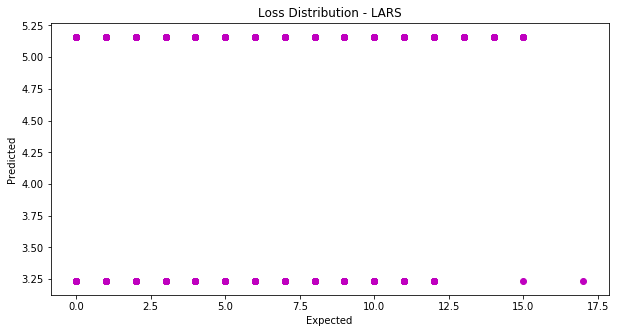

In [13]:
lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
trainModel(lars)
strategyArray.append("LARS")
#plotDistribution(lars)
plotGainDistribution(lars)
plotLossDistribution(lars)

[2.56544528 2.08705827 2.06124148 1.73541061 2.50367168] => 2.19 (+/- 0.62)
[2.38889728 2.13173761 2.2940429  2.50135111 2.3765175 ] => 2.34 (+/- 0.25)


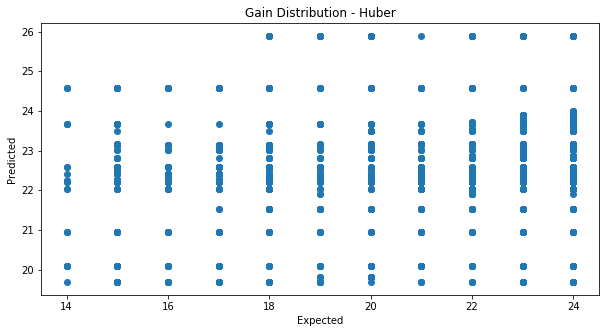

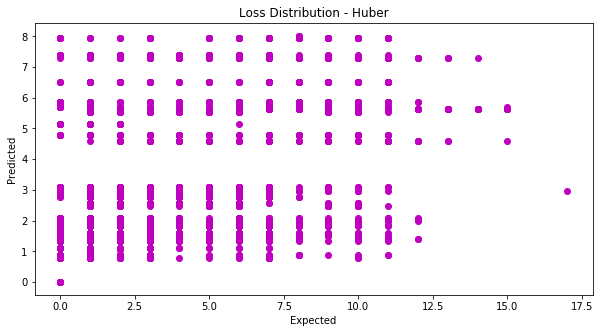

In [14]:
huber = MultiOutputRegressor(linear_model.HuberRegressor(max_iter = 10000))
trainModel(huber)
strategyArray.append("Huber")
#plotDistribution(huber)
plotGainDistribution(huber)
plotLossDistribution(huber)

[2.16517094 1.71139601 1.79786325 1.86588319 2.24059829] => 1.96 (+/- 0.42)
[2.06595442 2.1514245  2.38376068 3.11346154 2.82150997] => 2.51 (+/- 0.80)


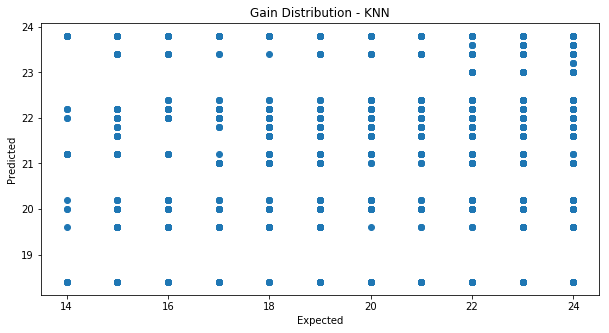

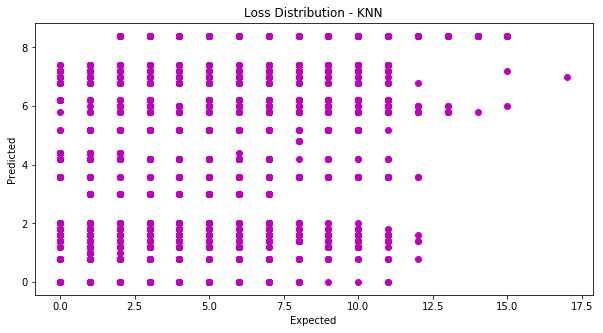

In [15]:
knn = MultiOutputRegressor(KNeighborsRegressor())
trainModel(knn)
strategyArray.append("KNN")
#plotDistribution(knn)
plotGainDistribution(knn)
plotLossDistribution(knn)

[2.50578289 1.83273221 2.0213887  1.71622302 2.11421525] => 2.04 (+/- 0.54)
[1.97226422 1.90929872 2.24030207 2.53345013 2.70411999] => 2.27 (+/- 0.62)


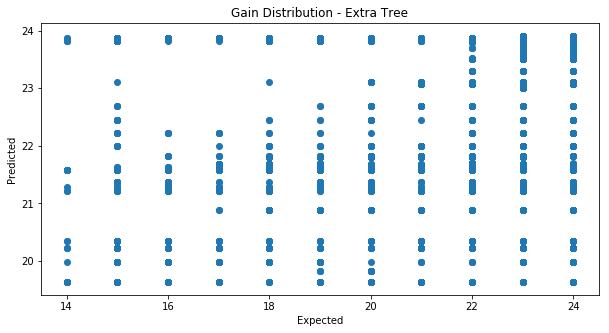

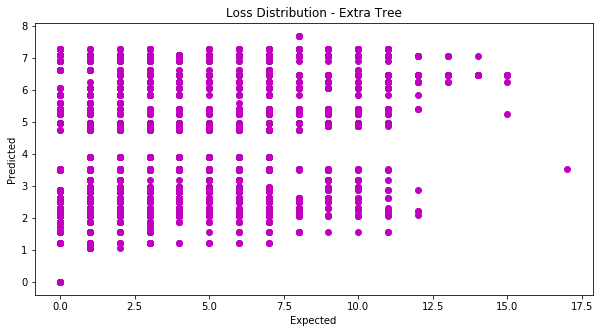

In [16]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
trainModel(bret)
strategyArray.append("Extra Tree")
#plotDistribution(bret)
plotGainDistribution(bret)
plotLossDistribution(bret)

[2.45341514 1.79503723 1.91621785 1.75252256 2.17441811] => 2.02 (+/- 0.53)
[1.93985405 1.95821983 2.17346024 2.49381226 2.92452947] => 2.30 (+/- 0.74)


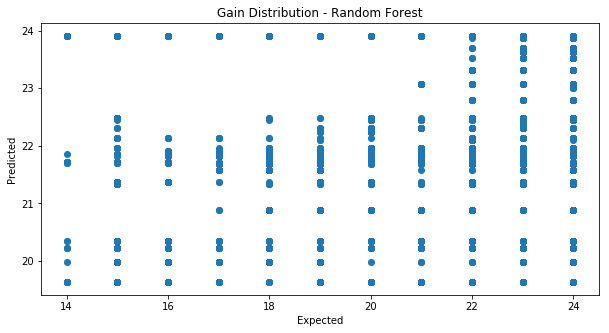

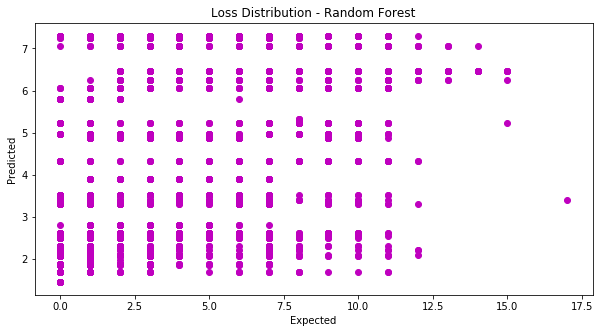

In [17]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(max_depth = 8, random_state = 0, n_estimators = 100)
trainModel(randomForest)
strategyArray.append("Random Forest")
#plotDistribution(randomForest)
plotGainDistribution(randomForest)
plotLossDistribution(randomForest)

# Plotting error boxplots

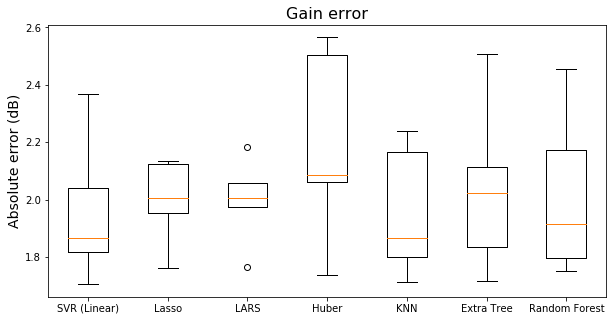

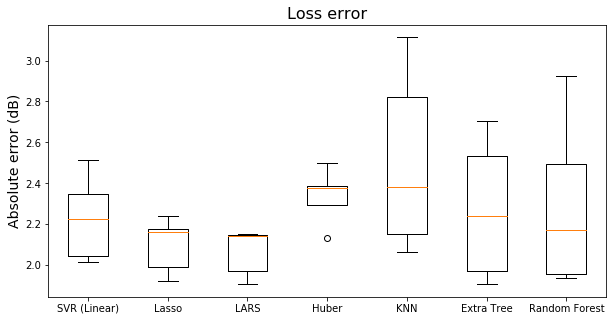

In [18]:
plotGainError()
plotLossError()